In [ ]:
from zipfile import ZipFile
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
zip_path = 'Cats and Dogs small.zip'

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('cats_dogs_small')

# Struktur sekarang: cats_dogs_small/train/, cats_dogs_small/test/
base_dir = 'cats_dogs_small'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['cats', 'dogs']


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Ambil model pretrained
model = models.resnet18(pretrained=True)

# Freeze semua layer awal
for param in model.parameters():
    param.requires_grad = False

# Ganti layer akhir (output 2 kelas)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [8]:
epochs = 10

# Inisialisasi list untuk menyimpan history training
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_train_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    test_loss = running_test_loss / len(test_loader)
    test_acc = 100 * correct_test / total_test

    # Simpan hasil ke list
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

    # STOP TRAINING jika train_acc dan test_acc >= 95%
    if train_acc >= 95.0 and test_acc >= 95.0:
        print(f"Stopping early at epoch {epoch+1} as Train and Test accuracy reached 95%")
        break

Epoch [1/10] | Train Loss: 0.4596 | Train Acc: 78.82% | Test Loss: 0.3141 | Test Acc: 87.86%
Epoch [2/10] | Train Loss: 0.2438 | Train Acc: 94.25% | Test Loss: 0.2290 | Test Acc: 90.71%
Epoch [3/10] | Train Loss: 0.1832 | Train Acc: 94.61% | Test Loss: 0.1917 | Test Acc: 93.57%
Epoch [4/10] | Train Loss: 0.1562 | Train Acc: 96.05% | Test Loss: 0.1688 | Test Acc: 95.00%
Stopping early at epoch 4 as Train and Test accuracy reached 95%


In [18]:
# Simpan model
torch.save(model.state_dict(), 'cats_dogs_model.pth')
print("Model berhasil disimpan ke 'cats_dogs_model.pth'")

Model berhasil disimpan ke 'cats_dogs_model.pth'


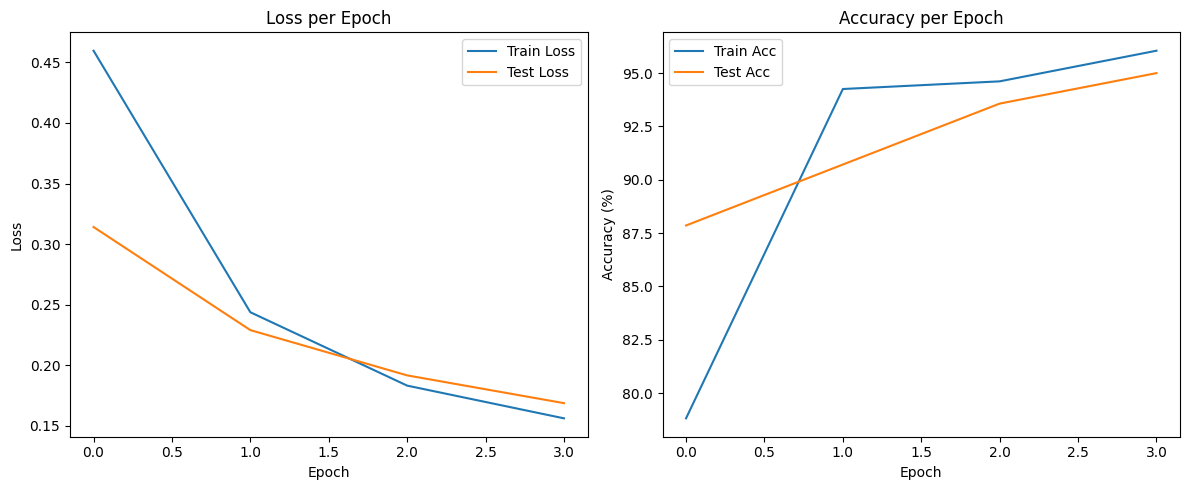

In [9]:
# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(test_accuracies, label='Test Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


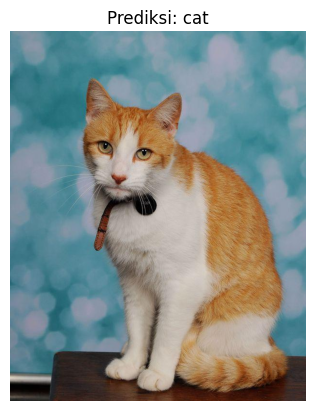

In [15]:
def predict_image(image_path, model, transform, class_names, device):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    return class_names[predicted.item()]

# Daftar nama kelas (sesuai folder train)
class_names = ['cat', 'dog']

# Contoh path gambar yang mau diprediksi
image_path = "cats_dogs_small/test/cats/cat_1.jpg"

# Prediksi kelas
predicted_label = predict_image(image_path, model, transform, class_names, device)

# Tampilkan gambar dan hasil prediksi
img = Image.open(image_path)

plt.imshow(img)
plt.title(f"Prediksi: {predicted_label}")
plt.axis('off')
plt.show()
